# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [50]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

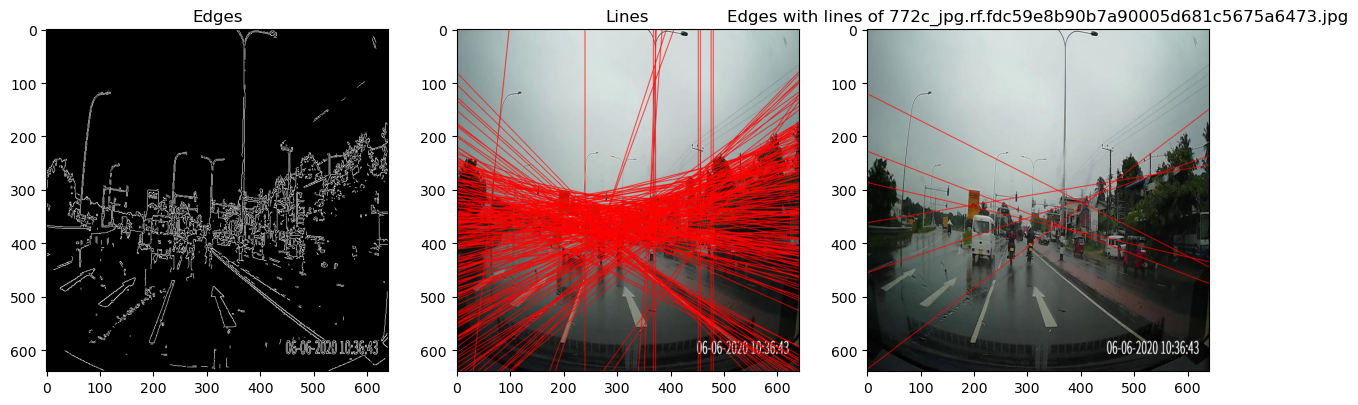

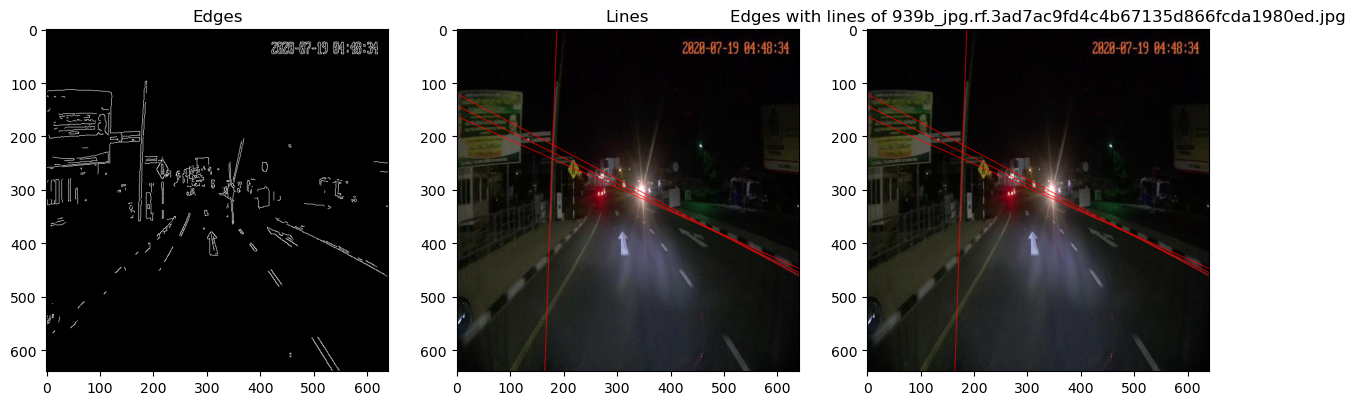

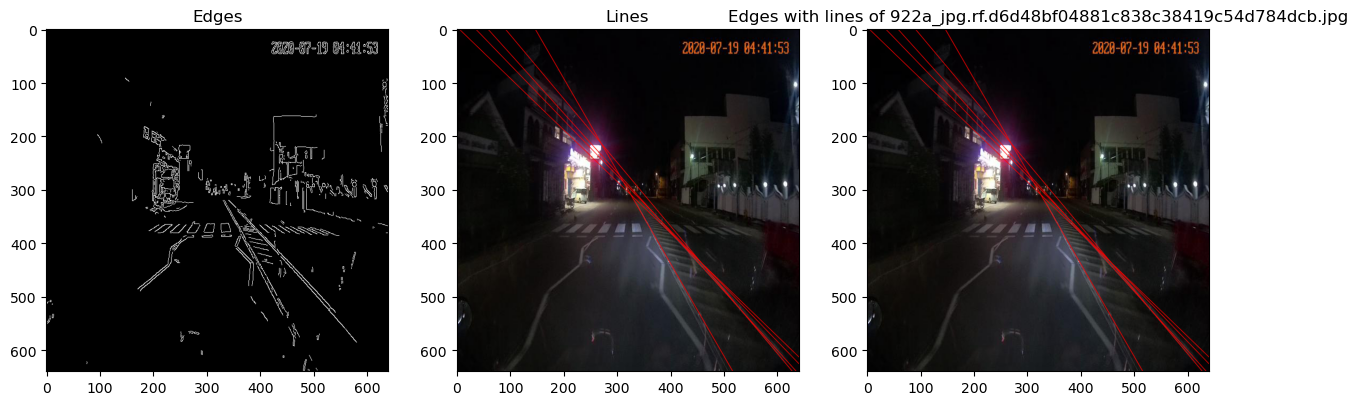

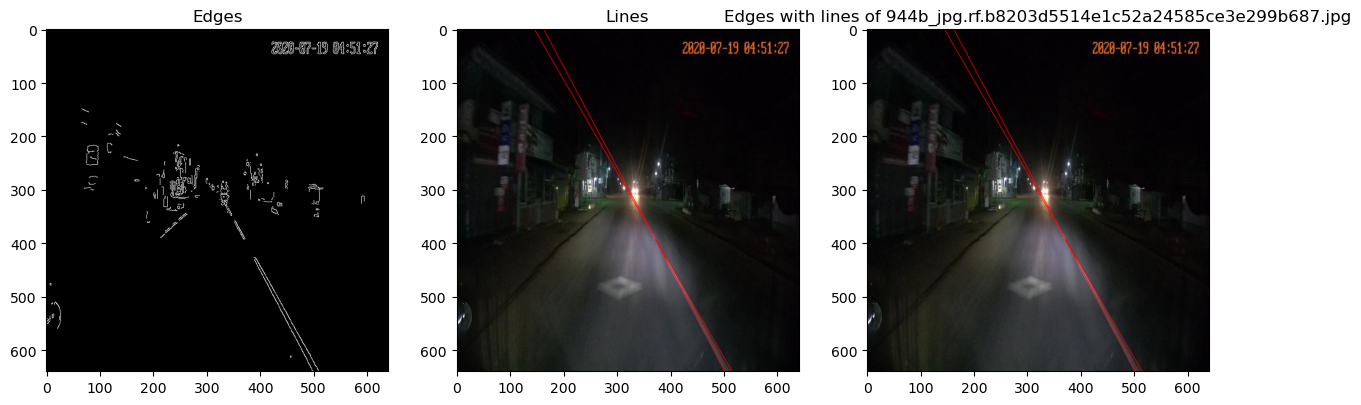

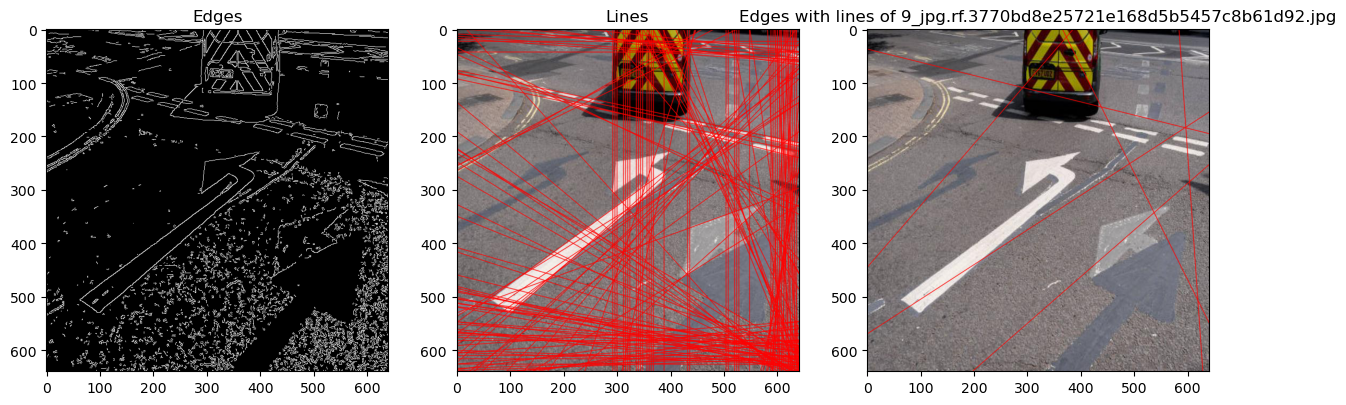

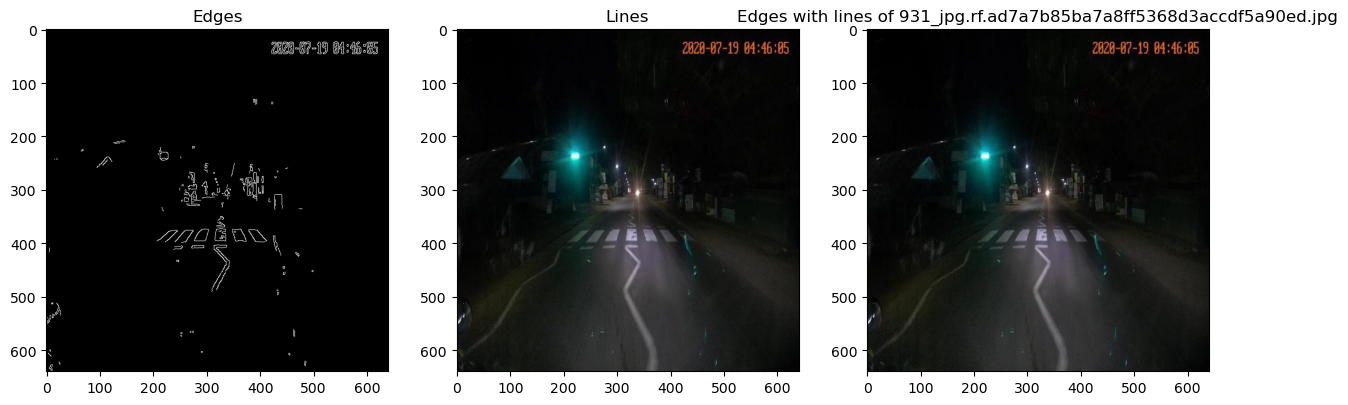

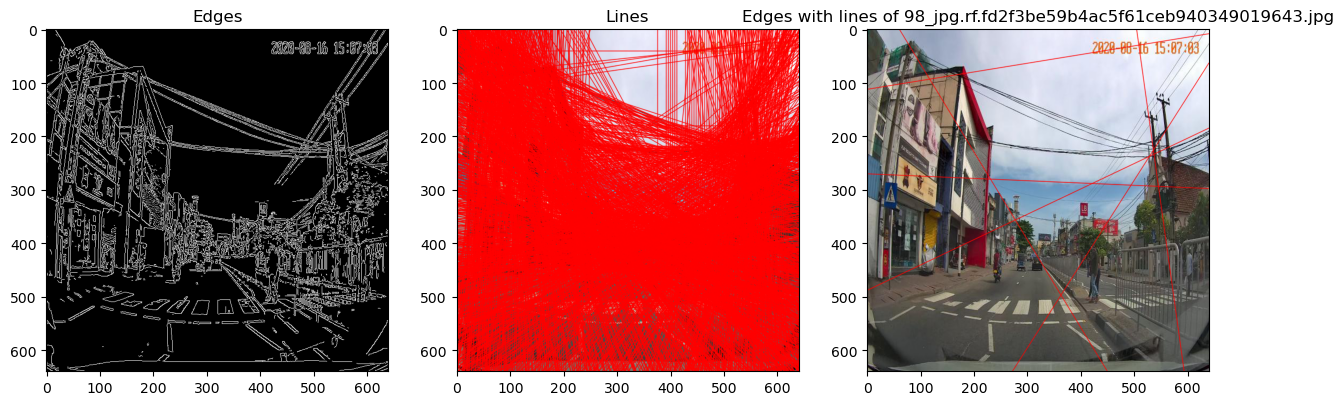

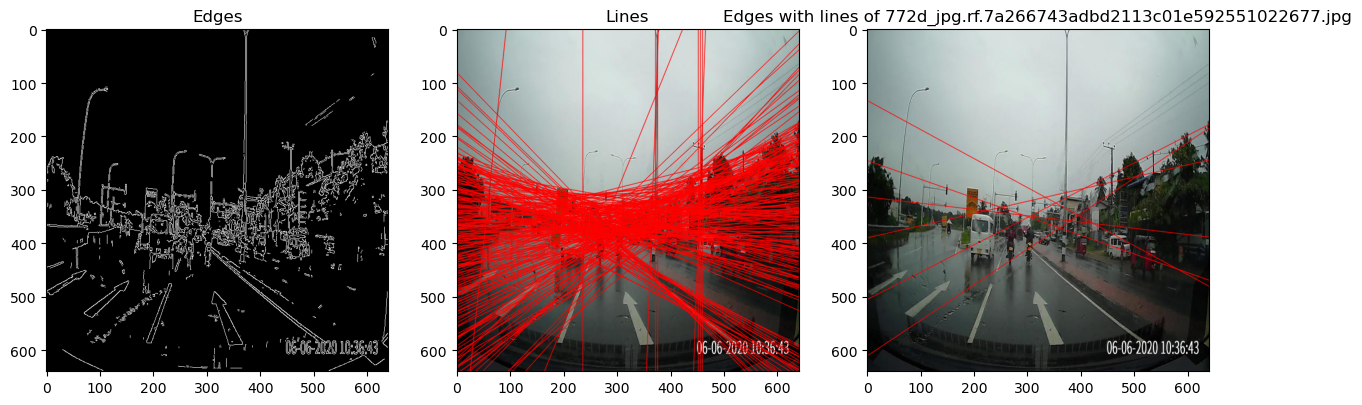

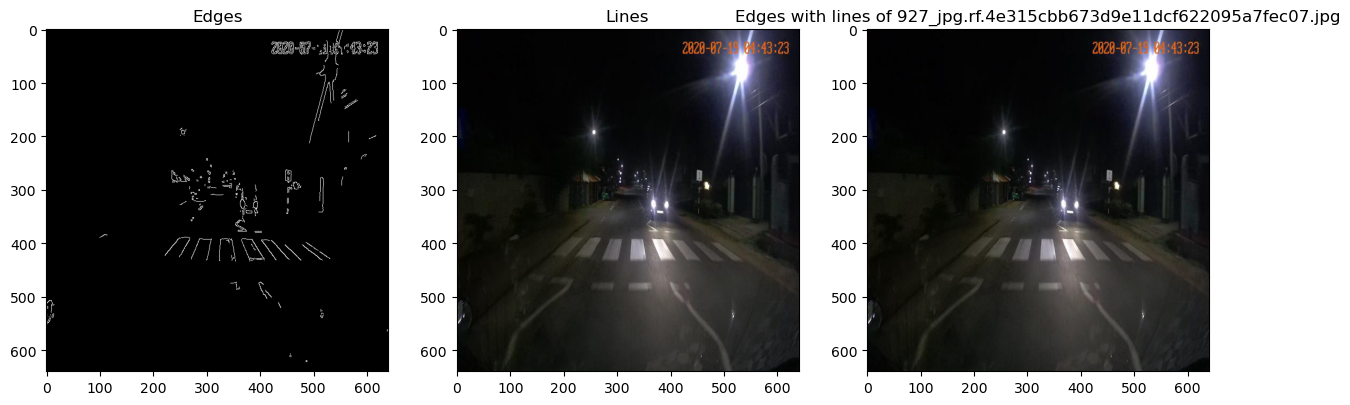

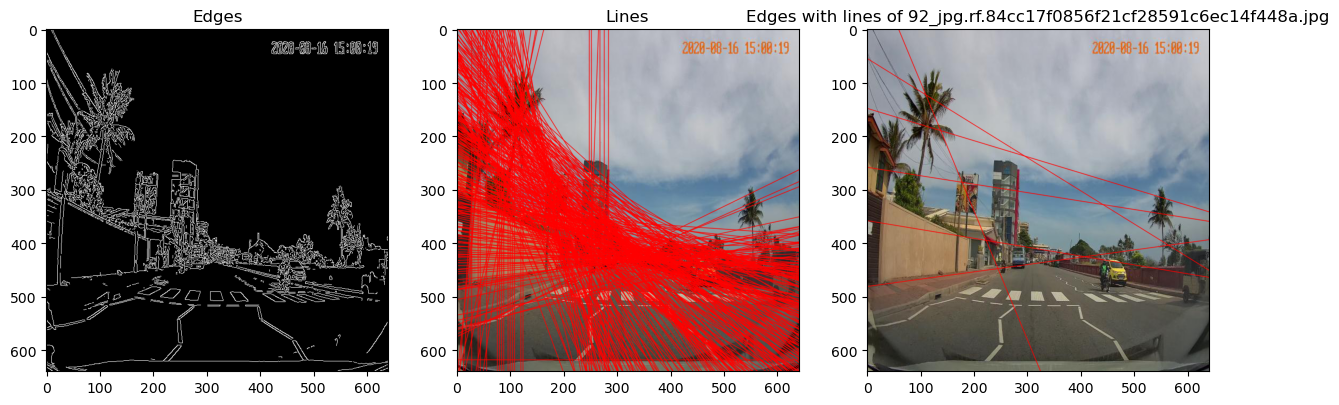

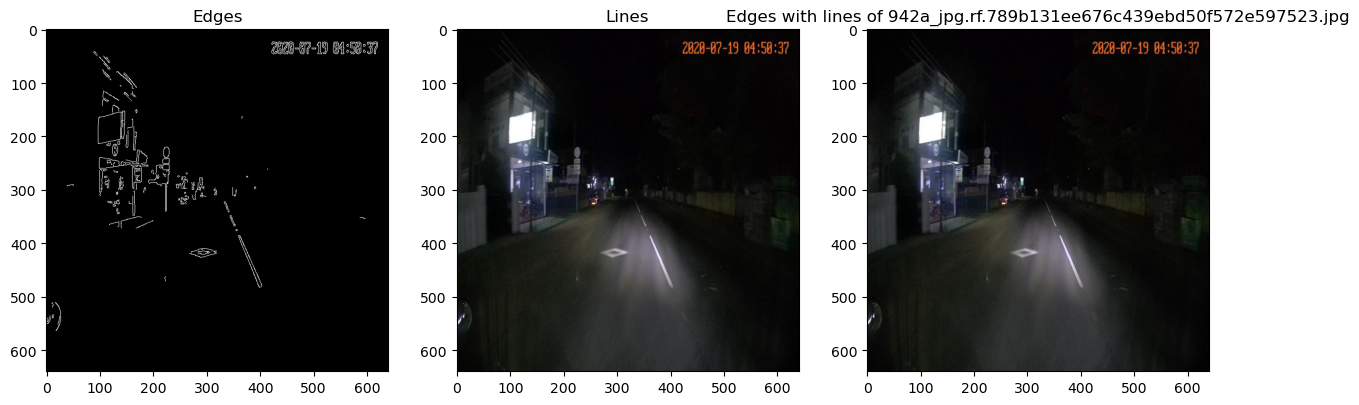

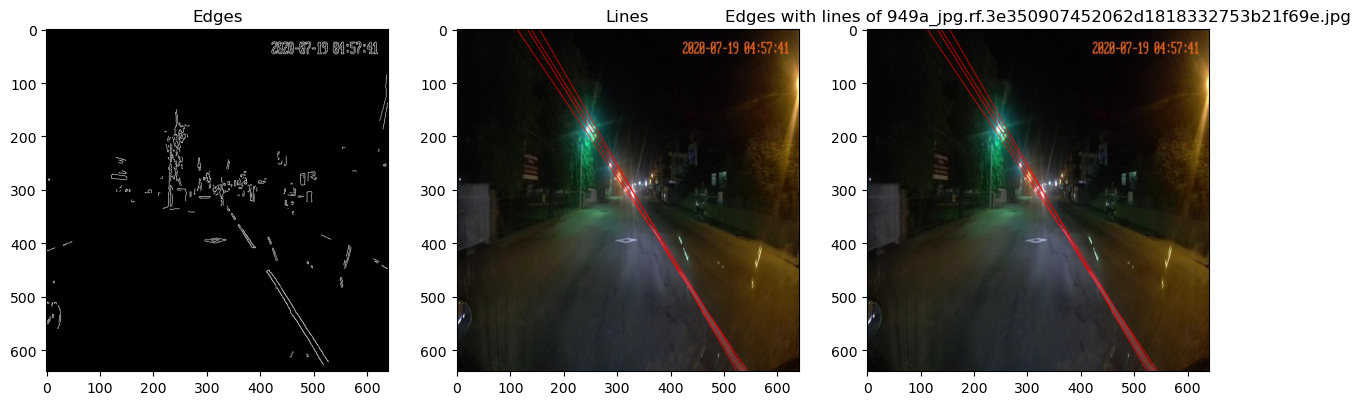

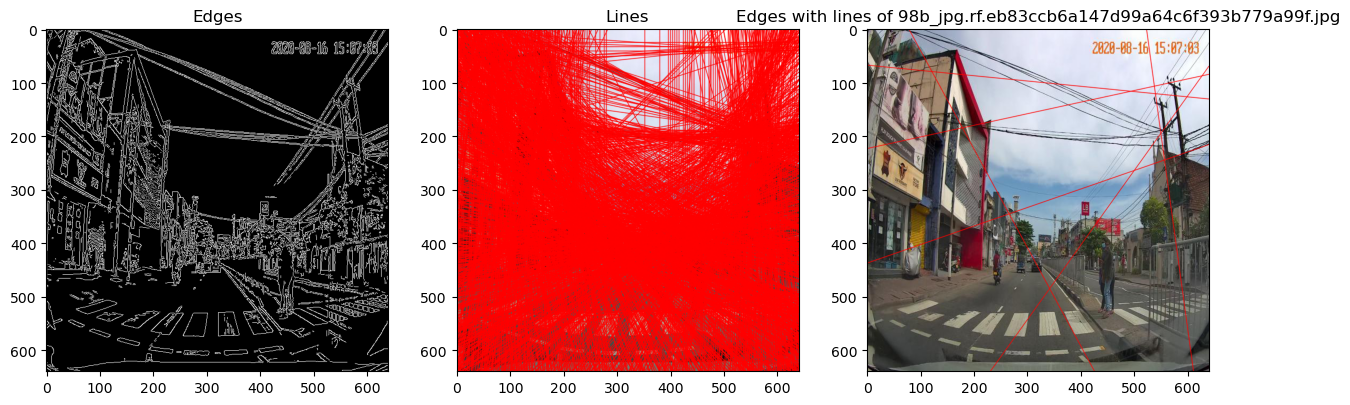

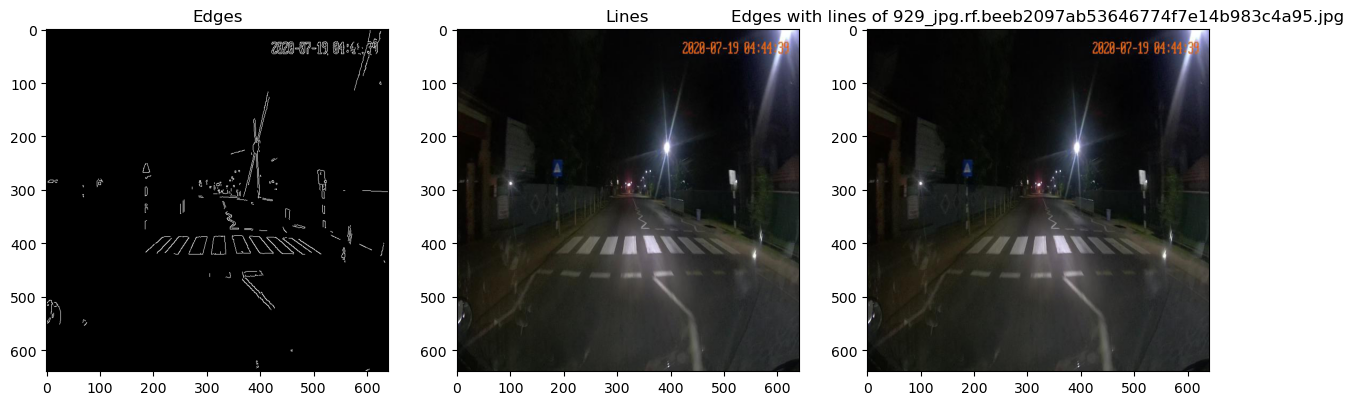

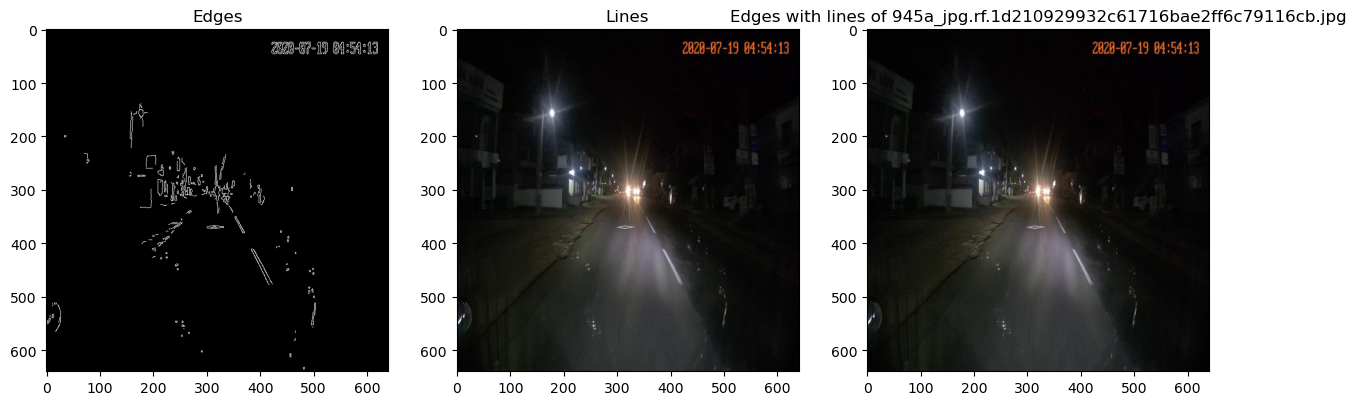

In [72]:
import os
import matplotlib.pyplot as plt

def paint_lines(lines, source):
    result = np.copy(source)

    for line in lines:
        rho = line[0]
        theta = line[1]

        a = math.cos(theta)
        b = math.sin(theta)

        x0 = a * rho
        y0 = b * rho

        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

        cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

    return result  # Return the result with drawn lines

def filter_by_k_means(lines, k=6):
    kmeans = KMeans(n_clusters=k).fit(lines)
    return kmeans.cluster_centers_

def process_images(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                source = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                edges = cv2.Canny(gray, threshold1=100, threshold2=150)

                # Get edges with lines drawn
                lines = cv2.HoughLines(edges, rho=2, theta=2*np.pi/180, threshold=190)
                if lines is not None:
                    lines = lines[:, 0, :]
                else:
                    lines = []

                if len(lines) > 6:
                    filtered_lines = filter_by_k_means(lines)
                else:
                    filtered_lines = lines

                plt.subplot(131), plt.imshow(edges, cmap='gray'), plt.title('Edges')
                plt.subplot(132), plt.imshow(paint_lines(lines, source), cmap='gray'), plt.title('Lines')
                plt.subplot(133), plt.imshow(paint_lines(filtered_lines, source), cmap='gray'), plt.title('Filtered lines')
                # Show edges with lines image
                plt.title(f'Edges with lines of {filename}')
                plt.show()

# Load all images from the dataset folder
dataset_folder = '../data/dataset'
images = process_images(dataset_folder)



In [29]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# gray = gray / 255

In [32]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, threshold1=100, threshold2=150)

# We are only interested in the road so we will remove everything above the horizon
#edges[0:350] = 0

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

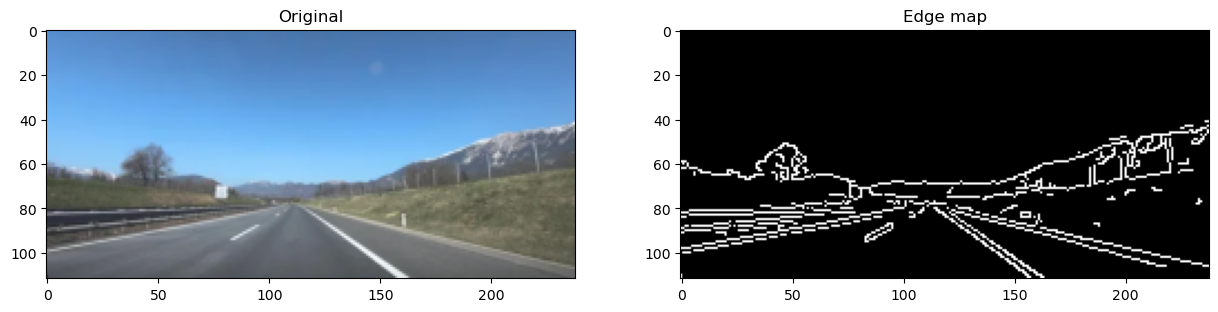

In [35]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

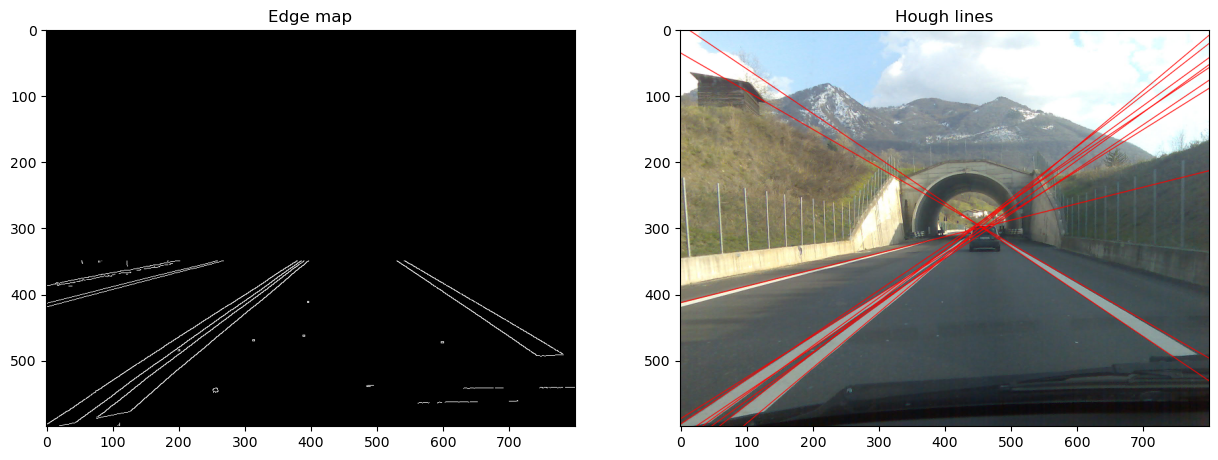

In [22]:
# Plot the resulting Hough lines
# result = np.copy(img)
#
# for line in lines:
#     rho = line[0]
#     theta = line[1]
#
#     a = math.cos(theta)
#     b = math.sin(theta)
#
#     x0 = a * rho
#     y0 = b * rho
#
#     pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
#     pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
#
#     cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)
#
# plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
# plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [34]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
# lines = cv2.HoughLines(edges, rho=2, theta=2*np.pi/180, threshold=190)
# hough = np.zeros_like(edges)
# # Let's get rid of the unnecessary dimension
# lines = lines[:, 0, :]

TypeError: 'NoneType' object is not subscriptable

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [25]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees).
# filtered_lines = []
# for line in lines:
#     # Extract theta for current line (remember Hough works with radians)
#     theta = line[1]
#     # Keep line if theta is not horizontal
#     if True:
#         filtered_lines.append(line)

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

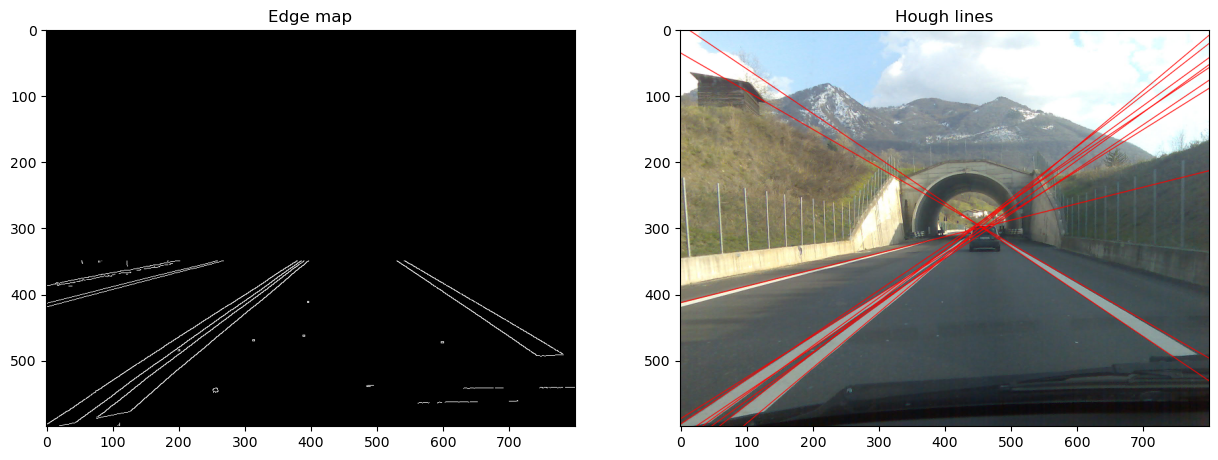

In [26]:
# Let's plot the resulting filtered lines
# result = np.copy(img)
#
# for line in filtered_lines:
#     rho = line[0]
#     theta = line[1]
#
#     a = math.cos(theta)
#     b = math.sin(theta)
#
#     x0 = a * rho
#     y0 = b * rho
#
#     pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
#     pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
#
#     cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)
#
# plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
# plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.

In [ ]:
# # We will apply k-means clustering to refine the detected lines.
# # Don't worry, we will learn about the clustering later in the course :-)
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=6).fit(filtered_lines)
# kmeans.cluster_centers_

In [ ]:
# Again, let's plot the resulting filtered lines
# result = np.copy(img)
#
# for line in kmeans.cluster_centers_:
#     rho =
#     theta =
#     ...
#
# plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
# plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

### Questions
* Do you see anything strange in the final result?
* Do you think the Hough transform resolution is important for obtaining a good result? Why?
* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?